In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
import pandas as pd, numpy as np
from scipy.stats import norm
from scipy.integrate import odeint
from scipy import optimize
sn.set_context('notebook')

# Beyond Metropolis: state-of-the-art MCMC

Back in notebook 4 we looked at the Metropolis algorithm, which is the basic building block of MCMC. It is *guaranteed* to converge on the target distribution, but we know that convergence will be *more efficient* if the **jump** (or **proposal**) distribution is similar to the target. This motivates the development of **adaptive** algorithms, where the proposal distribution is "tuned" as the Markov chain progresses.

There are lots of ways of implemeting adaptation (as well as various other innovations for improving the sampling efficiency), but a detailed description of modern MCMC algorithms is beyond the scope of these notes. What's more, if you're a hydrologist or an ecologist (rather than a statistician), you're probably more interested in *applying* MCMC than learning about all the mathematical details. Fortunately, if you understand the principles of the Metropolis algorithm (see [notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb)), you should be in a good position to use some more sophisticated MCMC packages without having to worry too much about the algorithms themselves.

In this notebook, we'll start off by introducing two Python packages that implement a variety of state-of-the-art MCMC algorithms. We'll then use one of these to calibrate the hydrological model developed in [notebook 5](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb).

**Note for anyone using this notebook "interactively"**: the MCMC code in this notebook may take a long time to run (the whole notebook takes more than an hour on my desktop machine). 

## 1. Useful Python packages

### 1.1. PyMC3

**[PyMC3]('https://github.com/pymc-devs/pymc3')** is a Python package offering a variety of sophisticated MCMC samplers, including **Hamiltonian Monte Carlo (HMC)** and the **No U-Turn Sampler (NUTS)**. It also provides a very clean syntax for model specification (defining priors, likelihoods etc.), as well as convenience functions for a wide range of distributions. This makes setting up a model and running MCMC very simple: as an illustration, check out the **linear regression** example in the [PyMC3 tutorial]('http://pymc-devs.github.io/pymc3/getting_started/'). This is very similar to the example covered in [notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb), except there we coded everything from scratch and used only a basic Metropolis algorithm. With PyMC3, the number of lines of code is dramatically reduced and we have the added advantage of being able to switch easily between several modern samplers.

However, a key property of the HMC and NUTS algorithms is they use the **gradient** of the target function to help tune the proposal distribution. This gives excellent performance for high-dimensional problems, but requires the target function to be **differentiable**. Unfortunately, as we have already seen in [notebook 3](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/03_Monte_Carlo.ipynb), for complex environmental models the likelihood function is often not well-behaved, so the posterior distribution is not differentiable and many of the advantages of the HMC and NUTS algorithms are lost.

### 1.2. emcee

**[emcee]('http://dan.iel.fm/emcee/current/')** is Python package which implements an **affine invariant MCMC ensemble sampler** (a more detailed description of the algorithm from the package authors is [here]('http://arxiv.org/abs/1202.3665')). This sampler uses **multiple chains** and *does not* require gradient information, which makes it ideal for the kinds of complex likelihoods commonly encountered in environmental modelling. Furthermore, although in high-dimensional parameter spaces the HMC or NUTS algorithms *may* be more efficient, the multiple chains used by emcee are easy to parallelise, which offers a significant performance advantage.

The downside of emcee is that, unlike PyMC3, there are no easy ways to specify your model: you have to write Python functions from scratch to represent your priors, likelihood and posterior. For simple models, this is not a major limitation, but for more complex likelihoods (e.g. more sophisticated error structures) the process can become time consuming.

[It is possible]('http://twiecki.github.io/blog/2013/09/23/emcee-pymc/') that the emcee algorithm will eventually be integrated into PyMC3, but in the meantime I recommend investigating both packages as they're useful in different situations. 

In this notebook we're going to use emcee.

## 2. Choosing a likelihood function

Before we run any MCMC, we need to decide on a likelihood function. In the previous examples in notebooks [2](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/02_Calibration_Likelihood.ipynb) and [4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb) we assumed a simple likelihood consisting of our **deterministic model**, $f(x, \theta)$ plus **independent and identically distributed Gaussian errors** with mean zero, $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon)$. However, as we will see, there are problems with using the same likelihood function for our hydrological model. First, we'll set up our model using the code from notebook 5.

In [2]:
def f(y, t, params):
    """ Define ODE system.
            y is list [V, S, G, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vi = y[0]
    Si = y[1]
    Gi = y[2]
    
    # Unpack params
    P, E, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    dS_dV = (((Vi - fc)*np.exp(fc - Vi))/(T_s*((np.exp(fc-Vi) + 1)**2))) + (1/(T_s*(np.exp(fc-Vi) + 1)))
    dV_dt = P - alpha*E*(1 - np.exp(-0.02*Vi)) - Si
    dS_dt = dS_dV*dV_dt
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    # Add results of equations to an array
    res = np.array([dV_dt, dS_dt, dG_dt, dDs_dt, dDg_dt])
    
    return res

def simple_hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ Runs the hydrological model.
    
            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        
            [Vs, S, G, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # List to store output
    output = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'Rainfall_mm']
        E = input_df.ix[idx, 'PET_mm']

        # Calculate S0 and G0 from Vs0 and Vg0
        S0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        G0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, S0, G0, 0, 0]

        # Model parameters
        params=[P, E, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of results
    df = pd.DataFrame(data=np.vstack(output),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)

    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = input_df['Runoff_mm']

    return df

We also need to read in the Tarland meteorological data that we will use to drive the model.

In [3]:
# Download real Tarland data into a Pandas dataframe
data_url = r'https://raw.githubusercontent.com/JamesSample/enviro_mod_notes/master/data/Tarland_Flow_And_Met_Data.csv'
met_df = pd.read_csv(data_url, parse_dates=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

The likelihood function we have used previously adds one additional parameter, $\sigma_\epsilon$, to our list of calibrating parameters. If we select values for $\alpha$, $\tau_s$, $\tau_g$ and $\sigma_\epsilon$, we can therefore run the model and generate some example output.

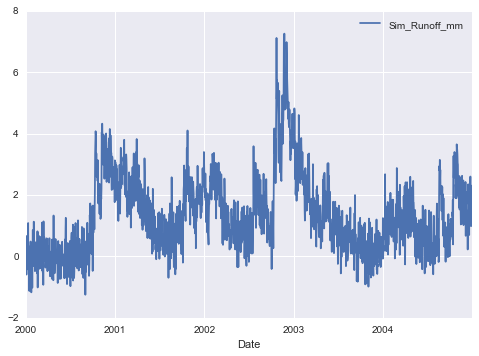

In [4]:
# Define *example* values for calibrating params
alpha_test = 0.8
T_s_test = 10
T_g_test = 100
sigma_e_test = 0.5

# Define fixed model parameters
beta = 0.6            # BFI (dimensionless)
fc = 290              # Field capacity (mm)
st_dt = '2000-01-01'  # Start date
end_dt = '2004-12-31' # End date

# Run the deterministic part of the model
ics = [0, 0] # Initial conditions for soil and groundwater volumes
mod_params = [alpha_test, beta, T_s_test, T_g_test, fc]
period = [st_dt, end_dt]
det = simple_hydro_model(met_df, ics, mod_params, period)

# Add the stochastic component N(0, sigma_e)
stoch = norm.rvs(loc=0, scale=sigma_e_test, size=len(det))
det['Sim_Runoff_mm'] = det['Sim_Runoff_mm'] + stoch

det[['Sim_Runoff_mm']].plot()

One problem with this error structure is immediately obvious from the plot above: by adding random noise with a fixed standard deviation, our model frequently predicts **negative runoff** when flows are low. This clearly doesn't make sense, and we can't solve the problem by simply setting values less than zero back to zero, because if we did our error distribution would no longer be Gaussian with mean zero.

Another problem with this likelihood can be seen from looking at the [very last plot in notebook 5](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb#4.-Summary), which shows simulated versus observed values. The model parameters used for this plot were chosen at random, so we don't expect them to give a good fit to the observed data. However, it is clear even from this rough example that the errors are likely to be **larger when flows are high** and **smaller when flows are low**. In other words, the errors are **[heteroscedastic](https://en.wikipedia.org/wiki/Heteroscedasticity)** and it is therefore not appropriate to use the same value of $\sigma_\epsilon$ for all flows.

One possible way to address both these issues is to make $\sigma_\epsilon$ proportional to the flow, $Q(t)$

$$\sigma_\epsilon = mQ(t)$$

If we do this, when $Q(t)$ is large we expect the error distribution to be wider, but as $Q(t)$ tends to zero, $\sigma_\epsilon$ also tends to zero, so there is a much lower chance of the model predicting negative values. Note that this formulation still only includes a single "error parameter", $m$, but the role of the error parameter in the likelihood function has changed slightly. Once we have estimated $m$, we can caluate $\sigma_\epsilon$ based on the flow time series and proceed as before.

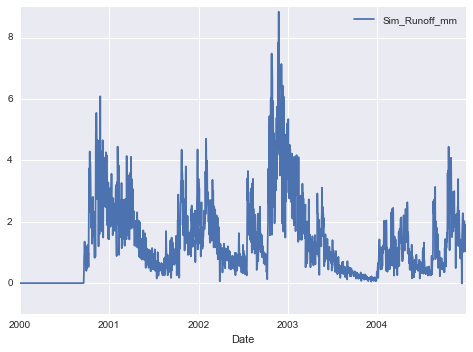

In [5]:
# Choose an *example* value for m
m_test = 0.3

# Run the deterministic model again
det = simple_hydro_model(met_df, ics, mod_params, period)

# Add the stochastic component N(0, m*Q)
stoch = norm.rvs(loc=0, scale=(m_test*det['Sim_Runoff_mm']), size=len(det))
det['Sim_Runoff_mm'] = det['Sim_Runoff_mm'] + stoch

det[['Sim_Runoff_mm']].plot()

This looks much better: the error variance is large during storm events and decreases as the hydrograph recesses, which matches our expections based the real data and the practical difficulties of estimating flow. Also note that, although it is still possible for the model to predict negative values, this is much **less likely** to happen than in the first example. Because negaive values happen very rarely, we can safely ignore them without dramatically truncating our error distribution.

When we come to calibrate the hydrological model, we will therefore **use a likelihood function that assumes the error variance increases with the flow**.

## 3. Parallel processing

To make the most of emcee, we will use **[`IPython.parallel`](http://ipython.org/ipython-doc/dev/parallel/)** to write code that can utilise a user-specified number of cores/processors. The first step is to launch multiple Python processes from the Jupyter `Clusters` tab on the `Home` screen, as shown in the image below

<img src="https://github.com/JamesSample/enviro_mod_notes/blob/master/images/Jupyter_Clusters_Tab.png?raw=true" alt="Jupyter clusters tab" width="700"> 

Once you've found the `Clusters` tab, set the `# of engines` equal to the number of cores or processors you have available and then click `Start`. This will create several new Python processes, which we can use to distribute the MCMC work.

Next, we set up our IPython notebook to make use of these extra processes. The `view` object in the code below will allow us to allocate our jobs.

In [6]:
from IPython import parallel
c = parallel.Client()
view = c.load_balanced_view()

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Each process has its own namespace, so in order to run our MCMC, each one will need access to all the data necessary to evaluate our log posterior function. There are several ways to ensure this, but one of the simplest is to use IPython's `%%px --local` magic operator. As described in more detail [here](http://twiecki.github.io/blog/2014/02/24/ipython-nb-cluster/), placing this at the start of a notebook code cell will execute the same code on **all** the available processes (i.e. all the processes created above under the `Clusters` tab, plus the main Python process hosting the current notebook). We can use this to make sure that each process has access to all the necessary modules, functions and variables.

In the sections below, I've reproduced the hydrological model code from above. We need to run it again, because this time we're also distributing it to our "worker" processes.  

Note also that the code here could (and should) be streamlined *a lot* to reduce the amount of processing required for each model evaluation. In any real-world application, performance tweaks at this stage are usually worth doing, because ultimately the model may be run tens of thousands of times by the MCMC algorithm. It is therefore worth spending a bit of time tidying up the code (and perhaps even optimising bits of it into e.g. Fortran or C), because small gains here can make a big difference later. In the code that appears below I *haven't* done this, because I want to maintain continuity with the ideas and code presented in the previous notebook.

### 3.1. Import modules 

In [7]:
%%px --local

import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm

### 3.2. Define the ODE system

The function below is used by `scipy.integrate.odeint` to solve the model equations at each time step.

In [8]:
%%px --local

def f(y, t, params):
    """ Define ODE system.
            y is list [V, S, G, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vi = y[0]
    Si = y[1]
    Gi = y[2]
    
    # Unpack params
    P, E, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    dS_dV = (((Vi - fc)*np.exp(fc - Vi))/(T_s*((np.exp(fc-Vi) + 1)**2))) + (1/(T_s*(np.exp(fc-Vi) + 1)))
    dV_dt = P - alpha*E*(1 - np.exp(-0.02*Vi)) - Si
    dS_dt = dS_dV*dV_dt
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    # Add results of equations to an array
    res = np.array([dV_dt, dS_dt, dG_dt, dDs_dt, dDg_dt])
    
    return res

### 3.3. Define the hydrological model

This function wraps the model equations in a loop to evaluate the drainage volume at each step in the input time series.

In [9]:
%%px --local

def simple_hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ Runs the hydrological model.
    
            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        
            [Vs, S, G, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # List to store output
    output = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'Rainfall_mm']
        E = input_df.ix[idx, 'PET_mm']

        # Calculate S0 and G0 from Vs0 and Vg0
        S0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        G0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, S0, G0, 0, 0]

        # Model parameters
        params=[P, E, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of results
    df = pd.DataFrame(data=np.vstack(output),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)

    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = input_df['Runoff_mm']

    return df

### 3.4. Define log likelihood

As discussed above, we will use a log likelihood that assumes **independent Gaussian errors**, but with the standard deviations, $\sigma_\epsilon$, proportional to the flow, $Q(t)$. This is a pretty sensible starting point for hydrological modelling, but there are some other issues we are not addressing here. For example, because we are working with time series data we know the errors are unlikely to be independent - most environmental time series exhibit **[autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)** to some degree. It is possible to modify the likelihood function to include autocorrelation too, but we won't go into this yet, because there are some subtleties to consider.

Note that in the function below we've introduced the parameter $m$, which is used to estimate the value of $\sigma_\epsilon$ for each point in the time series.

In [10]:
%%px --local

def log_likelihood(mcmc_params, met_df):
    """ mcmc_params    Vector of parameters [alpha, T_s, T_g, m]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log likelihood.
    """   
    # Extract calibrating parameter values
    alpha, T_s, T_g, m = mcmc_params
    
    # Run deterministic model with these parameters
    df = simple_hydro_model(met_df=met_df,
                            ics=[0, 0], # Assume ics at start of model run are always 0
                            mod_params=[alpha, beta, T_s, T_g, fc],
                            period=[st_dt, end_dt])
    
    # Discard the first year of simulations
    df = df.truncate(before='2001-01-01')    

    # Extract arrays for simulated and observed runoff
    sim = df['Sim_Runoff_mm']
    obs = df['Obs_Runoff_mm']

    # Calculate sigma_e for each step
    sigma_e = m*sim

    # Calculate log likelihood. For each element in the arrays sim, sigma_e and obs,
    # this code calculates the log prob of drawing 'obs' from a Gaussian centred on 
    # 'sim' with std. dev. 'sigma_e'. (See Section 2 of notebook 2 for explanation)
    likes = norm(sim, sigma_e).logpdf(obs)
    
    # If flow is zero, sigma_e is zero and scipy.norm returns NaN
    # Set these to -inf instead
    likes[np.isnan(likes)] = -np.inf
    
    # Sum log likes
    ll = np.sum(likes)
    
    return ll

### 3.5. Define log prior

We must define prior distributions for the model parameters we intend to calibrate (plus the standard deviation of the error term in our likelihood function, which is now controlled by $m$). The model parameters of interest are $\alpha$, $\tau_s$ and $\tau_g$ and, for the sake of simplicity, we will assume **uniform distributions** for all of them.

Note that the constants `alpha_max` etc. in the code below will be specified later.

In [11]:
%%px --local

def log_prior(mcmc_params):
    """ mcmc_params is the vector of parameters [alpha, T_s, T_g, m]
    
        Returns the log prior probability of p
    """
    # Extract calibrating parameter values
    alpha, T_s, T_g, m = mcmc_params
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    if ((0 <= alpha < alpha_max) and (0 <= T_s < T_s_max) and 
        (0 <= T_g < T_g_max) and (0 <= m < m_max)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

### 3.6. Define log posterior

The **log posterior distribution** is (proportional to) the sum of the log prior and the log likelihood. The code below is almost identical to that used in [Section 7.5 of notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#7.5.-Define-posterior).

In [12]:
%%px --local

def log_posterior(mcmc_params, met_df):
    """ mcmc_params    Vector of parameters [alpha, T_s, T_g, m]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log posterior.
    """   
    # Get log prior prob
    log_pri = log_prior(mcmc_params)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(mcmc_params, met_df)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

### 3.7. Read the input data

Ultimately, we want to use the real data from the Tarland catchmemnt to calibrate our model. Before we do that, however, it is worth **testing our entire workflow** using some synthetic data to assess our approach.

As discussed previously, one of the trickiest parts of any MCMC analysis is formulating an appropriate **likelihood function**. If we get the likelihood function wrong, our parameter estimates and their associated uncertainty will be **biased**, and it is difficult to assess how biased without knowing the **true** likelihood function. Because we never have this information in reality (assuming it even exists), it can be difficult to know whether our method is produing sensible results.

One way to gain confidence in a statistical methodology is to generate "fake" data with a known error structure, which we can use to test our method. If our MCMC algorithm can recover the "fake true" parameters with reasonable accuracy under ideal circumstances (i.e. when we know the exact form of the likelihood function), then perhaps it will also have a chance of identifying meaningful parameter sets in the real world, when we don't know the error structure in detail. On the other hand, if the algorithm struggles even under ideal test conditions (e.g. due the model being over-parameterised compared to the amount of test data available), it is very unlikely to yield meaningful results in any real application.

This may sound like a lot of extra work, but it's actually very easy. Once you have your model and have decided on an error structure (i.e. once you've written down your likelihood function, which you need to do anyway), it is very easy to simulate fake observations that can be used for testing. In fact, we've already done this above in section 2, where we assumed some "true" values for $\alpha$, $\tau_s$, $\tau_g$ and $m$ and then ran our model to check the error structure seemed sensible.

In the code that follows, we will use the dataset created above as a **synthetic observed time series**. If the MCMC algorithm can recover the "fake true" parameter values using the synthetic data, it should be easy to re-run the analysis using the *real* observed dataset instead; if it can't, we'll need to work out why and refine the approach.

Note that, once again, some of the code from above is repeated here as we need to run it on the "worker" processes we intend to use for parallelising emcee.

In [13]:
%%px --local

# Define "fake true" values for calibrating params
alpha_true = 0.8
T_s_true = 10
T_g_true = 100
m_true = 0.3

# Define fixed model parameters
beta = 0.6            # BFI (dimensionless)
fc = 290              # Field capacity (mm)
st_dt = '2000-01-01'  # Start date
end_dt = '2004-12-31' # End date

# Download real Tarland data into a Pandas dataframe
data_url = r'https://raw.githubusercontent.com/JamesSample/enviro_mod_notes/master/data/Tarland_Flow_And_Met_Data.csv'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

# Truncate
met_df = met_df.truncate(before=st_dt, after=end_dt)

# Run the model
ics = [0, 0]
mod_params = [alpha_true, beta, T_s_true, T_g_true, fc]
period = [st_dt, end_dt]
df = simple_hydro_model(met_df, ics, mod_params, period)

# Add the stochastic component N(0, m*Q)
stoch = norm.rvs(loc=0, scale=(m_true*df['Sim_Runoff_mm']), size=len(df))
df['Runoff_mm'] = df['Sim_Runoff_mm'] + stoch

# Replace 'Runoff_mm' col in met_df with fake values from df
met_df['Runoff_mm'] = df['Runoff_mm']

### 3.8. Define prior ranges

We have already decided to use **uniform distributions with lower limits of 0** for all our priors, but we still need to specify the upper limit for each distribution.

The parameter $\alpha$ is a correction factor applied to the PET data. We know from [notebook 5](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb#1.1.-The-study-catchment) that the PET estimates are likely to be too high, so we expect $\alpha$ to be no bigger than about 1. Searching within a prior range from 0 to 2 therefore seems reasonable.

$$\alpha \sim \mathcal{U}(0, 2)$$

$\tau_s$ and $\tau_g$ are both very poorly constrained, so we will set wide priors on those.

$$\tau_s \sim \mathcal{U}(0, 100) \qquad and \qquad \tau_g \sim \mathcal{U}(0, 500)$$

Finally, $m$ is a multiplicative factor applied to $Q(t)$ to estimate $\sigma_\epsilon$. An upper limit of 1 seems like a reasonable starting point, but we can always return later and broaden this range if it appears to be too narrow.

$$m \sim \mathcal{U}(0, 1)$$

In [14]:
%%px --local

# Define upper limits for uniform priors
# (lower limits are all 0)
alpha_max = 2
T_s_max = 100
T_g_max = 500
m_max = 1

### 3.10. Find the MAP

As noted above, [emcee](http://dan.iel.fm/emcee/current/) makes use of multiple chains (also called "**walkers**"), which are the equivalents of the "*drunken mountaineers with walkie-talkies*" in my dodgy analogy from [notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#6.-Multiple-chains). We therefore need to decide on sensible **starting locations** for each of our walkers. 

One way to do this is to use an optimiser to estimate the **[Maximum a Posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)** density, just as we did in [section 7.7 of notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#7.7.-Choose-a-starting-location). This is the maximum of the posterior distribution, so starting our walkers in the vicinity of this point is equivalent to helicoptering all the "mountaineers" to top of the highest summit in the region. This is as good a place as any for them to begin their random search, and starting in an area of high posterior density improves the chances of the chains converging efficiently. Of course, we don't want to start all the walkers from *exactly* the same place, so having found the MAP we'll add a small amount of random noise, so that each starts from a slightly different location that is *close to* (but not actually on) the posterior "summit". From here, each walker can head off in his/her own direction to explore the surrounding region.

In [15]:
def neg_log_posterior(mcmc_params, met_df):
    """ Negative of log posterior.
    """
    return -log_posterior(mcmc_params, met_df)

def find_map(init_guess, met_df):
    """ Estimate the location of the maximum of the posterior density.
    
            init_guess   Initial guess for starting optimiser
                         [alpha, T_s, T_g, m]
            met_df       Data frame of meteorological data
    """
    # Run optimiser
    param_est = optimize.fmin(neg_log_posterior, init_guess, args=(met_df,))

    return param_est

# Guess some starting values for [alpha, T_s, T_g, m]
param_guess = [0.75, 10., 100., 0.5]

# Run optimiser
param_est = find_map(param_guess, met_df)

# Print results
print '\n'
for idx, param in enumerate(['Alpha', 'Tau_s', 'Tau_g', 'm']):
    print 'Estimated %s: %.2f.' % (param, param_est[idx])

Optimization terminated successfully.
         Current function value: 459.914283
         Iterations: 137
         Function evaluations: 243


Estimated Alpha: 0.80.
Estimated Tau_s: 9.94.
Estimated Tau_g: 100.93.
Estimated m: 0.30.


Although the optimiser takes a while to run, it does an excellent job of identifying the "fake true" parameter values we used to generate the synthetic observations. Ultimately, this step should actually save time, because the MCMC algorithm will hopefully converge more quickly due to using the MAP as an approximate starting point.

### 3.10. Sample from the posterior using emcee

We're now ready to use emcee to draw samples from the posterior. Although the optimiser has already done a good job of identifying the "best" parameter values, we still need to know **how much confidence** we should have in this result. This is where the MCMC comes in.

Note that the code in the cell below *does not* need the `%%px --local` magic operator, because emcee will handle distributing the MCMC chains to our "worker" processes (each of which now has all the information necessary to run the model).

 

Average acceptance fraction:  0.59675


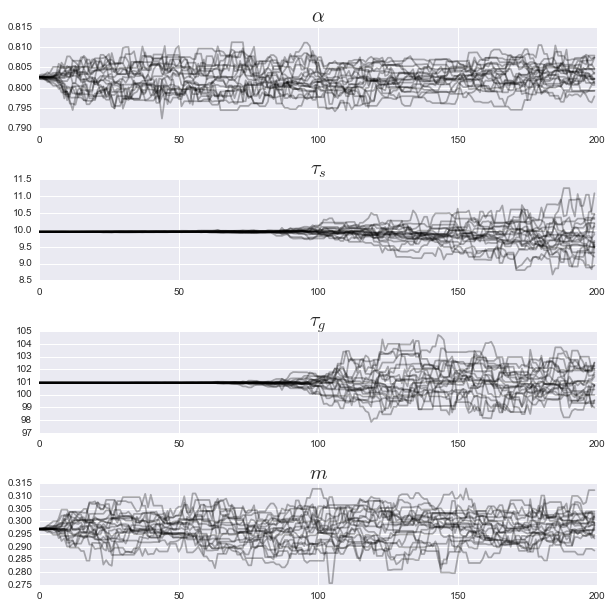

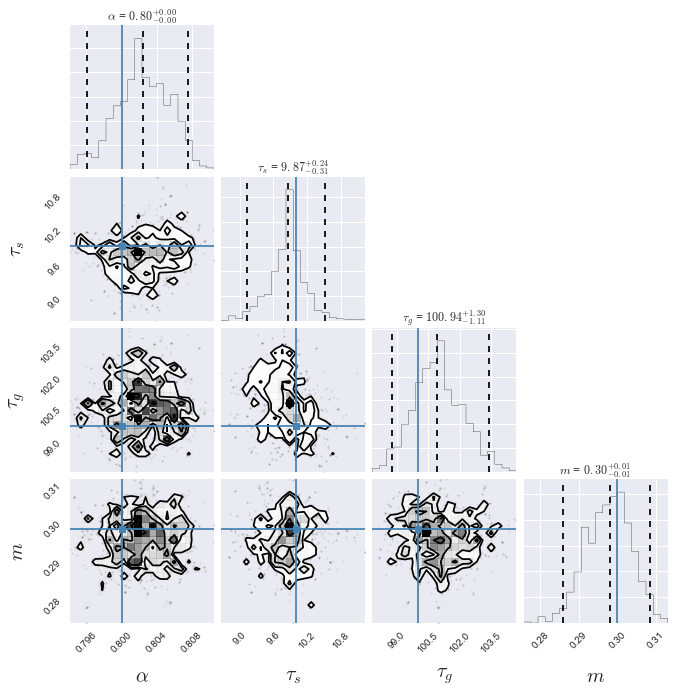

In [17]:
# emcee parameters
n_dim = 4      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard

def run_mcmc(n_dim, n_walk, n_steps, n_burn, param_opt, truths=None):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            param_opt  Optimised parameter set from find_map()
            truths     True values (if known) for plotting
        
        Produces plots of the chains and a 'corner plot' of the
        marginal posterior distribution.
        
        Returns an array of samples (with the burn-in discarded).
    """
    # Generate starting locations for the chains by adding a small
    # amount of Gaussian noise to optimised MAP
    starting_guesses = [param_opt + 1e-4*np.random.randn(n_dim) 
                        for i in range(n_walk)]

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    # Note the poo=view argument, which tells emcee how to interface with our
    # "worker" processes
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                    pool=view, args=[met_df,])

    # Run sampler
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats. based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    #print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    param_labels = [r'$\alpha$', r'$\tau_s$', r'$\tau_g$', r'$m$']
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.subplots_adjust(hspace=0.5)    
    plt.show()

    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

    # Triangle plot
    tri = corner.corner(samples,
                        labels=param_labels,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})

    return samples

samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, 
                   [alpha_true, T_s_true, T_g_true, m_true])

## 3. Evaluating the results

The plots above are reassuring: the chains have all converged nicely and the posterior distributions for each parameter (the histograms along the diagonal of the bottom plot) nicely identify the "true" parameter values. On these histograms, blue vertical lines mark the "true" values and the black dotted lines mark the 2.5%, 50% and 97.5% quantiles. It is nice to see that all the true values lie within the 95% credible intervals, and in most cases the median MCMC estimate is very close correct value.

The **acceptance fraction** is the average acceptance rate across all the chains and the value here seems pretty reasonable - see [section 4 of notebook 4](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/04_MCMC.ipynb#4.-Convergence-efficiency) for some guidance regarding acceptance rates. The **autocorrelation time** gives an indication of the number of evaluations of the posterior needed to produce an independent sample of the target density. Again, there are no hard-and-fast rules regarding how this metric should be interpreted, but a useful guide is that sampling for approximately 10 autocorrelation times should ensure you have a representative posterior sample. In this case, the autocorrelation times for each parameter suggest we should have allowed the algorithm to run for a bit longer - perhaps 300 steps in total and discarding the first ~200 as burn-in. For a real application it might be worth re-running the MCMC, but for this illustrative example these chains seem sufficiently well-converged.

Having sampled from the posterior, we are now in a position to estimate the **parameter-related** and **predictive** uncertainties in our model output. The parameter-related uncertainty is the uncertainty due to variability in our three calibrating model parameters $\alpha$, $\tau_s$ and $\tau_g$. This represents our confidence in the **mean** of the model output, ignoring the stochastic error term. The overall predictive uncertainty is the parameter-related uncertainty **plus** the additional stochastic uncertainty introduced by the error parameter $m$. The overall predictive uncertainty is what matters most in terms of assessing the fit of our model, but a useful feature of the Bayesian approach is that it allows partitioning of uncertainty into parameter-related and random components. 

To visualise the results in the domain of our original data (i.e. as a time series) we can draw $N$ parameter sets at random from the MCMC chains (after discarding the burn-in, so we're only selecting from the "converged" portion). For each parameter set we run the model, and the median and range of the model output *before adding on the stochastic error component* gives an indication of the parameter-related uncertainty. We can then add-on the additional uncertainty from $m$ to give an overall 95% credible interval around the median simulation.

In the code below I've used the excellent **[mpld3 library](http://mpld3.github.io/)** to create the plot, so you should be able to click the magnifying glass near the bottom left corner and zoom in to see the uncertainty bounds on the simulated curve.

In [18]:
def get_uncertainty_intervals(n_sets, samples):
    """ Get 95% credible intervals for parameter-related and predictive 
        uncertainty around the simulated median.
        
            n_sets      Number of parameters sets to sample
        
        Returns two data frames [param_only, overall]
        
            param_only  95% CI and median for parameter-related uncertainty
            overall     95% CI and median for overall predictive uncertainty
    """
    # Store output data in lists
    param_only = []
    overall = []

    # Pick parameter sets at random from the converged chains
    for alpha, T_s, T_g, m in samples[np.random.randint(len(samples), size=n_sets)]:
        # Reset initial conditions
        Vs0 = 0.       # Initial soil volume (mm)
        Vg0 = 0.       # Initial groundwater volume (mm)

        # Run model
        df = simple_hydro_model(met_df=met_df,
                                ics=[Vs0, Vg0],
                                mod_params=[alpha, beta, T_s, T_g, fc],
                                period=[st_dt, end_dt])

        # Discard burn-in
        df = df.truncate(before='2001-01-01')

        # Copy df without adding stoch component
        param_only.append(df[['Sim_Runoff_mm']].copy())

        # Add in the error uncertainty associated with m
        stoch = norm.rvs(loc=0, scale=(m*df['Sim_Runoff_mm']), size=len(df))

        # Add stochastic component to deterministic output
        df['Sim_Runoff_mm'] = df['Sim_Runoff_mm'] + stoch

        # Add to output
        overall.append(df[['Sim_Runoff_mm']])

    # Concatenate results
    param_only = pd.concat(param_only, axis=1)
    overall = pd.concat(overall, axis=1)

    # Get 2.5 and 97.5 percentiles for plotting
    param_only = param_only.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overall = overall.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]

    return [param_only, overall]
  
# Number of param sets to use
n_sets = 100

# Get uncertainty intervals
param_only, overall = get_uncertainty_intervals(n_sets, samples)

# Get observed data
obs = met_df[['Runoff_mm']].truncate(before='2001-01-01', after=end_dt)

# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(overall.index, overall['2.5%'], overall['97.5%'], 
                 color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(param_only.index, param_only['2.5%'], param_only['97.5%'], 
                 color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(param_only.index, param_only['50%'], 'r-', label='Median simulated')
plt.plot(obs.index, obs['Runoff_mm'], 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

The darker red shading on the plot above represents the 95% credible interval for the **parameter-related** uncertainty, which in this case is very narrow because our marginal posteriors are so sharply defined (you'll need to zoom in a long way to even see the parameter-related uncertainty interval on the plot). The lighter red shading defines the 95% credible interval for the **overall predictive** uncertainty, which in this case is dominated by the stochastic error term.

The next step is to **check whether our assumptions regarding the likelihood function have been met**. There are many ways to do this, some being more sophisticated than others. One simple but useful diagnostic plot is to look at the **standardised residuals**, $\epsilon_{std}$ of the model compared to the observations

$$\epsilon_{std} = \frac{\epsilon_{raw}}{\sigma_\epsilon}$$

where $\epsilon_{raw}$ is the difference between modelled and (fake) observed values and $\sigma_\epsilon$ is the standard deviation used at that particular time point (calculated as $mQ(t)$). It is usual to plot the residuals for just a single parameter set taken from somewhere near the **MAP**. The plot below uses residuals for the **median** set of parameters from the converged MCMC chains.

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


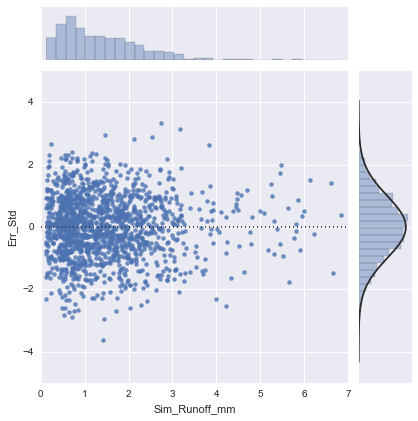

In [19]:
def plot_residuals(samples):
    """ Plot standardised residuals for median parameter set.
    """
    # Get the median param set
    alpha_med, T_s_med, T_g_med, m_med = np.median(samples, axis=0)

    # Run model
    med = simple_hydro_model(met_df=met_df,
                             ics=[0, 0],
                             mod_params=[alpha_med, beta, T_s_med, T_g_med, fc],
                             period=[st_dt, end_dt])

    # Discard burn-in
    med = med.truncate(before='2001-01-01')
        
    # Calc raw errors for median param set
    med['Err_Raw'] = med['Obs_Runoff_mm'] - med['Sim_Runoff_mm']

    # Calc sigma_e as m*Q(t)
    med['sigma_e'] = m_med*med['Sim_Runoff_mm']

    # Calc standardised residuals
    med['Err_Std'] = med['Err_Raw']/med['sigma_e']

    # Plot
    sn.jointplot('Sim_Runoff_mm', 'Err_Std', data=med, 
                 kind='resid')

    return med

med = plot_residuals(samples)

It's good to see that there is no obvious structure to the residuals, which also seem to be normally distributed with mean zero (as we originally assumed). We should also check for **autocorrelation** here, but because this is just an example where we *know* the residuals are independent (because we generated them that way in section 2, above), we'll postpone looking at autocorrelation until we're working with some *real* data.

Another easy-to-calculate metric that can be informative is the **coverage**. This is the proportion of the observations lying within the **overall predictive 95% credible interval**. If all is well with our approach, we can expect roughly 95% of the observations to be located in this region. 

In [20]:
def calc_coverage(med, overall):
    """ Calculates the percentage "coverage".
        
            med      Data frame of median simulation from 
                     plot_residuals()
            overall  Data frame of overall predictive 
                     uncertainty from get_uncertainty_intervals()
    """
    # Add obs data to 'overall' data frame
    overall['Obs'] = med['Obs_Runoff_mm']

    # Work out which observations lie within the 95% interval
    overall['In_Int'] = ((med['Obs_Runoff_mm']>=overall['2.5%']) & 
                         (med['Obs_Runoff_mm']<=overall['97.5%']))

    # Calculate coverage
    cov = overall['In_Int'].sum()/float(len(overall))
   
    return cov

cov = calc_coverage(med, overall)
print 'Coverage: %.2f' % (cov*100)

Coverage: 93.02


Again, it is reassuring to see that the actual coverage is in close agreement with the theoreticaly expected value of 95%.

## 4. Real data

So far, we have demonstrated that our approach using emcee is capable of identifying correct parameter sets and uncertainty ranges in our hydrological model *as long as the likelihood function is known exactly*. It's now time to try the analysis using some **real observations**, where the assumptions of our likelihood function are less likely to be satisfied. 

### 4.1. Read the input data

We'll begin by reading-in a new copy of the meteorological data to all of our "worker" processes, replacing the modified "fake" dataset we created earlier.

In [21]:
%%px --local

# Download real Tarland data into a Pandas dataframe
data_url = r'https://raw.githubusercontent.com/JamesSample/enviro_mod_notes/master/data/Tarland_Flow_And_Met_Data.csv'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

### 4.2. Adjust the priors

We will also broaden the prior on $\tau_g$, by increasing the upper limit from $500$ to $2000 \; days$.

In [22]:
%%px --local

# Define upper limits for uniform priors
# (lower limits are all 0)
alpha_max = 2
T_s_max = 100
T_g_max = 2000
m_max = 1

### 4.3. Find the MAP

Next, we'll run the optimiser again to find a good satrting point for our "walkers".

In [23]:
# Guess some starting values for [alpha, T_s, T_g, m]
param_guess = [0.75, 10., 100., 0.5]

# Run optimiser
param_est = find_map(param_guess, met_df)

# Print results
print '\n'
for idx, param in enumerate(['Alpha', 'Tau_s', 'Tau_g', 'm']):
    print 'Estimated %s: %.2f.' % (param, param_est[idx])

Optimization terminated successfully.
         Current function value: 776.311881
         Iterations: 333
         Function evaluations: 582


Estimated Alpha: 0.78.
Estimated Tau_s: 12.35.
Estimated Tau_g: 1830.43.
Estimated m: 0.55.


### 4.4. Run the MCMC

And now we can run the MCMC. Note that in the code below `truths=None` because, unlike our previous test example, we no longer know what the answer should be.



Average acceptance fraction:  0.6165


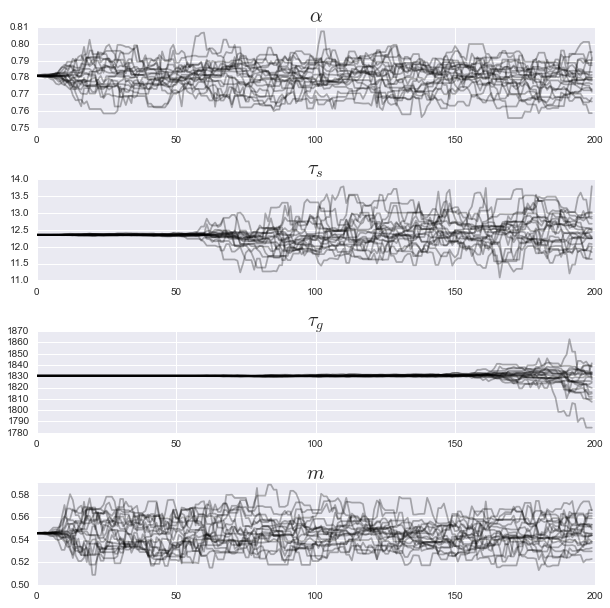

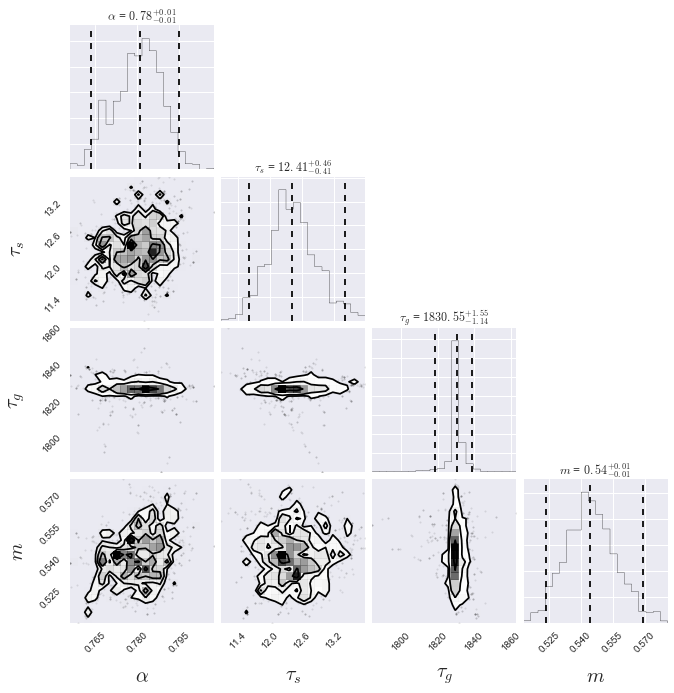

In [24]:
samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, truths=None)

Given that we're using real data, the MCMC chains above have converged very nicely. However, it is worth noting that the posterior histogram for $\tau_g$ is probably unrealistically "spiked", because it is clear from the trace plot for this parameter that the chains didn't properly diverge from the MAP until after about step 150. Because we've only discarded the first 100 steps as burn-in, our sample for $\tau_g$ will not be truly independent of the original starting location. Although this would probably not affect the median estimate for $\tau_g$, for any real application it would be worth re-running the MCMC with a larger number of steps to ensure the posterior samples are genuinely representative.

The median value of $\alpha = 0.78$ seems physically reasonable based on the discussion in [notebook 5](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb#1.1.-The-study-catchment), and the value of $\tau_s = 12.3 \; days$ is also perfectly credible. The value of $\tau_g = 1830 \; days \approx 5 \; years$ seems rather large, but is not out-of-the-question. 

All the posteriors are well-defined and **unimodal**, which is nice to see. 

Next, we'll plot the median simulated time series and the 95% credible intervals, which we can compare with the observed runoff series.

In [25]:
# Get uncertainty intervals
param_only, overall = get_uncertainty_intervals(n_sets, samples)

# Get observed data
obs = met_df[['Runoff_mm']].truncate(before='2001-01-01', after=end_dt)

# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(overall.index, overall['2.5%'], overall['97.5%'], 
                 color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(param_only.index, param_only['2.5%'], param_only['97.5%'], 
                 color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(param_only.index, param_only['50%'], 'r-', label='Median simulated')
plt.plot(obs.index, obs['Runoff_mm'], 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

The 95% credible interval for **parameter-relatated** uncertainty on the plot above is absolutely tiny, emphasising just how narrow the marginal posteriors are. The median simulation also does a reasonable job of matching the recession rate in the real dataset, and the results are clearly better than the example we started with at the end of [notebook 5](http://nbviewer.ipython.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb#4.-Summary). 

On the other hand, it is also true that the model is failing to properly simulate the timing and magnitude of the main flood peaks, and it's also significantly overestimating baseflow during dry periods (e.g. summer 2003). Both these features suggest the **estimated groundwater residence time may be too high** - see below for further discussion.

## 5. Evaluate the results

A plot of standardised residuals is shown below. Although clearly not as neat as the example above using synthetic data, the overall appearance is still broadly of **Gaussian errors with mean zero**, as we assumed by our likelihood function.

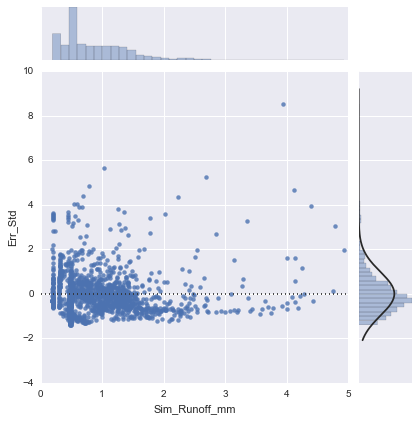

In [26]:
med = plot_residuals(samples)

The **coverage** is also about right, which is reassuring.

In [27]:
cov = calc_coverage(med, overall)
print 'Coverage: %.2f' % (cov*100)

Coverage: 94.87


The final assumption made by our likelihood function is that of **serially independent** errors i.e. there should be no **autocorrelation** in the rediduals. In the plot below, the solid and dashed grey lines respectively represent the 95% and 99% confidence bands for autocorrelation. It is clear that significant autocorrelation is present in the residuals, which will have led to bias in our MCMC results.

Dealing with autocorrelation is possible, but not straightforward, and the hydrological literature includes a number of recent papers describing the advantages and disadvantages of different ways of modifying the likelihood. 

In these notes I won't go any further with autocorrelation, but it may be worth investigating the literature (e.g. [here](https://www.researchgate.net/profile/Guillaume_Evin/publication/260343217_Comparison_of_joint_versus_postprocessor_approaches_for_hydrological_uncertainty_estimation_accounting_for_error_autocorrelation_and_heteroscedasticity/links/548b184a0cf225bf669f8374.pdf)) if you're interested.

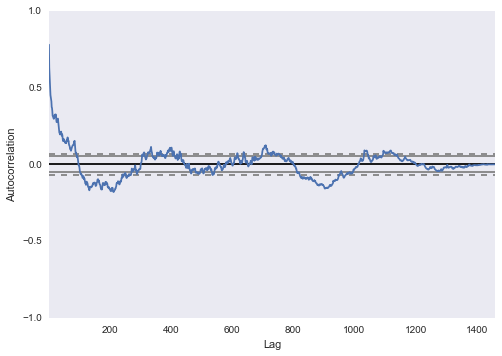

In [28]:
pd.tools.plotting.autocorrelation_plot(med['Err_Std'])

## 6. A final assessment

The model does a pretty good job of simulating the essential features of the observed data, including getting the recession time about right and correctly identifying most major flow events to within the range of predictive uncertainty. In addition, although there are certainly opportunities for improvements, the overall approach has been successful and the results seem statistically coherrent.

The key question is, of course, **is the model actually useful?** The answer depends on what we hope to use it for, but it's fair to say that this model *wouldn't* be much use in most situations of genuine interest, such as investigating **high flows** (e.g. to assess flooding) or **low flows** (e.g. to assess drought indices or ecological impacts). It's clear from the time series plot above that, although the model does OK *on average*, it doesn't accurately represent the magnitude of major flood peaks, nor does it do a very good job of capturing baseflow during long dry spells (especially the significant drought during 2003). 

Part of the reason for this is that the model is too simple - there are literally dozens of processes *we know* are important in catchment hydrology that we haven't included in our conceptualisation. For example, during major storm events much of the incoming water may run over the surface directly to the stream, without entering the soil "reservoir" at all. This water is often referred to as **infiltration excess** and it can be a significant component of the fast, "flashy" response of some streams during periods of high rainfall. Without at least incorporating some representation of this **overland flow** into our model, it's probably unreasonable to expect it to accurately represent the size of flow peaks during large storms. 

Similarly, the calibrated groundwater residence time, $\tau_g$, of $1800 \; days$ is very large for a catchment such as Tarland. The result of this in our model is to produce a steady, largely unresponsive level of baseflow, which is maintained even during long drought periods (e.g. 2003) - unlike in the observed dataset. One explanation for this issue relates to the way we parameterised our likelihood function at the start of this notebook. Because the error standard deviation, $\sigma_\epsilon$, is assumed to be proportional to flow, if the flow goes to zero then so does $\sigma_\epsilon$ and our code assigns $-\infty$ to the posterior probability. This implies that any parameter set resulting in zero drainage to the stream at any time step is automatically **deemed to be impossible**, so the algorithm is likely to favour longer groundwater residence times that are capable of maintaining flows through dry periods (like 2003). One common alternative is to introduce an additional parameter to the error structure by estimating $\sigma_\epsilon$ as

$$\sigma_\epsilon = c + mQ(t)$$

A second reason for the algorithm to favour large values of $\tau_g$ is that we have only used the model to simulate 5 years' worth of data, which is insufficent for the groundwater to properly equilibrate if $\tau_g = 1830 \; days$. Once near equilibrium, a groundwater store with such a large residence time would have a high outflow rate, which would likely be incompatible with the observed data. It is possible that either running the model for longer, or setting initial conditions closer to a plausible equilibrium state, would yield smaller estimates for $\tau_g$.

## 7. Summary

  1. Getting the **likelihood function** (approximately) right is the only way to get your **inference** (approximately) right. <br><br>
  
  2. Before using a complicated model with a complicated MCMC procedure and your **real dataset**, it's worth generating some **test data** to see if you can identify the correct parameters under ideal conditions. If not, you'll need to modify your approach. <br><br>
  
  3. The Bayesian method makes it possible to **apportion your uncertainty to different sources**. Here we've only looked at **parameter-related** and **overall predictive** uncertainty, but more sophisticated approaches (e.g. **[BATEA](http://www.sciencedirect.com/science/article/pii/S0022169406002745)** can do more). <br><br>
  
  4. It's important to **check your assumptions** and **modify them if necessary**. We've only considered the most basic diagnostic plots - there are lots of other options to investigate. <br><br>
  
  5. Just because your **marginal posteriors** look nice and your **credible intervals look credible**, doesn't mean your model is actually **useful**!